## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras

from keras.datasets import cifar10
from keras.utils import np_utils

import warnings
warnings.filterwarnings('ignore')

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = np_utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [9]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
import itertools

from keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from sklearn.metrics import accuracy_score

# 試比較 save_best_only 與否的差異
save_best_only_list = [True, False]

# 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test
save_weights_only = True

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for save_best_only in save_best_only_list:
    model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                                 monitor="val_loss", 
                                 save_best_only=save_best_only)
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[model_ckpt]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = (f"save_best_only: {save_best_only}")
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

    pred_final = model.predict(x_test) # 預測
    
    # Load back
    model = keras.models.load_model("./tmp.h5")
    loss_loadback, acc_loadback = model.evaluate(x_test, y_test)
    pred_loadback = model.predict(x_test)

    final_model_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=pred_final.argmax(axis=-1))
    loadback_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=pred_loadback.argmax(axis=-1))

    print(f"Accuracy of {exp_name_tag} final weights: %.3f" % final_model_acc)
    print(f"Accuracy of best weights: %.3f" % loadback_acc)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 hidden_layer3 (Dense)       (None, 128)               3289

Epoch 47/50
49/49 [==============================] - 3s 68ms/step - loss: 0.5561 - accuracy: 0.8374 - val_loss: 1.6611 - val_accuracy: 0.4885
Epoch 48/50
49/49 [==============================] - 4s 72ms/step - loss: 0.5371 - accuracy: 0.8445 - val_loss: 1.6607 - val_accuracy: 0.4922
Epoch 49/50
49/49 [==============================] - 3s 70ms/step - loss: 0.5225 - accuracy: 0.8510 - val_loss: 1.6501 - val_accuracy: 0.4951
Epoch 50/50
313/313 [==============================] - 1s 3ms/step - loss: 1.4464 - accuracy: 0.4925
Accuracy of save_best_only: True final weights: 0.488
Accuracy of best weights: 0.492
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                        

Epoch 42/50
49/49 [==============================] - 3s 66ms/step - loss: 0.6189 - accuracy: 0.8108 - val_loss: 1.5924 - val_accuracy: 0.4983
Epoch 43/50
49/49 [==============================] - 3s 68ms/step - loss: 0.6005 - accuracy: 0.8198 - val_loss: 1.6101 - val_accuracy: 0.4898
Epoch 44/50
49/49 [==============================] - 3s 65ms/step - loss: 0.5787 - accuracy: 0.8278 - val_loss: 1.6350 - val_accuracy: 0.4941
Epoch 45/50
49/49 [==============================] - 3s 63ms/step - loss: 0.5638 - accuracy: 0.8340 - val_loss: 1.6493 - val_accuracy: 0.4831
Epoch 46/50
49/49 [==============================] - 3s 66ms/step - loss: 0.5475 - accuracy: 0.8415 - val_loss: 1.6439 - val_accuracy: 0.4948
Epoch 47/50
49/49 [==============================] - 3s 66ms/step - loss: 0.5309 - accuracy: 0.8460 - val_loss: 1.6758 - val_accuracy: 0.4901
Epoch 48/50
49/49 [==============================] - 3s 66ms/step - loss: 0.5149 - accuracy: 0.8533 - val_loss: 1.6690 - val_accuracy: 0.4907
Epoch 

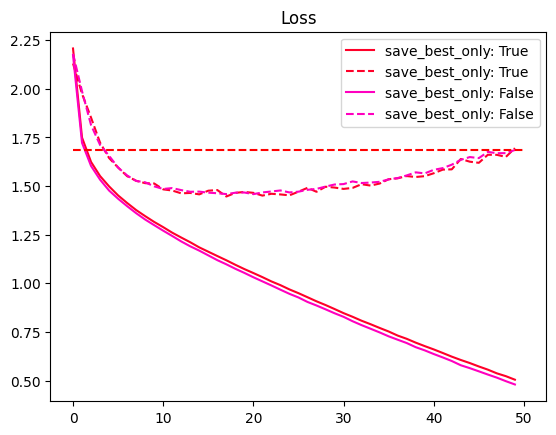

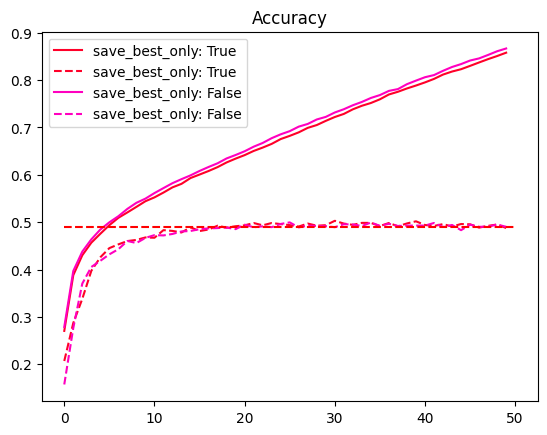

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
from matplotlib import cm as mplcm
from matplotlib import colors

NUM_COLORS = 2

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.title("Loss")
plt.legend()
plt.show()

for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.title("Accuracy")
plt.legend()
plt.show()